In [1]:
import numpy as np # linear algebra
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from tpot import TPOTClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print("Setup Complete")

/kaggle/input/blood-transfusion-dataset/transfusion.csv
Setup Complete


In [2]:
#Importing the data base 
donation_filepath = "../input/blood-transfusion-dataset/transfusion.csv"
transfusion = pd.read_csv(donation_filepath)
print("Setup Complete")

Setup Complete


In [3]:
#inspecting the 5 first rows
transfusion.head()


,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [4]:
transfusion.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [5]:
#creating target column

transfusion.rename(columns={'whether he/she donated blood in March 2007': 'target'}, inplace=True)
transfusion.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),target
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


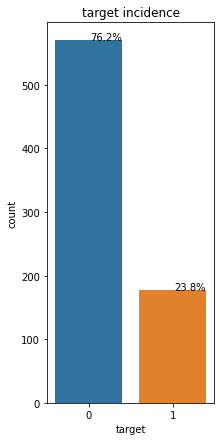

In [6]:
#Checking target incidence
#figure parameters
plt.figure(figsize=(3,7))
plt.xlabel('Target')
plt.ylabel('Occurence')
plt.title('target incidence')
#ploting 
ax=sns.countplot(x='target', data=transfusion )
#annotating the percentage
total = float(len(transfusion))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.show()

In [7]:
#extracting x and y from dataframe
x=transfusion.drop(columns='target', axis=1)
y=transfusion['target']
print(y.value_counts(normalize=True)*100)
print(y.value_counts(normalize=True)*100)

0    76.203209
1    23.796791
Name: target, dtype: float64
0    76.203209
1    23.796791
Name: target, dtype: float64


In [8]:
#Splitting transfusion into train and test datasets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=1, stratify=y)
print(x.shape,x_train.shape,x_test.shape)
print(y.shape,y_train.shape,y_test.shape)
print(y_train.value_counts(normalize=True)*100)
print(y_test.value_counts(normalize=True)*100)

(748, 4) (598, 4) (150, 4)
(748,) (598,) (150,)
0    76.254181
1    23.745819
Name: target, dtype: float64
0    76.0
1    24.0
Name: target, dtype: float64


In [9]:
#Selecting model using TPOT
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2,n_jobs=-1)
tpot.fit(x_train, y_train)
tpot.export('tpot_digits_pipeline.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8076470588235294

Generation 2 - Current best internal CV score: 0.8076470588235294

Generation 3 - Current best internal CV score: 0.8076470588235294

Generation 4 - Current best internal CV score: 0.8076470588235294

Generation 5 - Current best internal CV score: 0.8076470588235294

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.55, min_samples_leaf=9, min_samples_split=3, n_estimators=100)


In [10]:
#cheking AUC 
logreg_auc_score=roc_auc_score(y_test, tpot.predict_proba(x_test)[:,1])
print(f'\nAUC score : {logreg_auc_score:.4f}')


AUC score : 0.7378


In [11]:
#cheking tpot score
print(tpot.score(x_test, y_test))

0.7666666666666667


In [12]:
#cheking the best model chosen by tpot
tpot.fitted_pipeline_

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_features=0.55,
                                        min_samples_leaf=9,
                                        min_samples_split=3))])

In [13]:
#Checking the variance
np.var(transfusion)

Recency (months)         6.544782e+01
Frequency (times)        3.405192e+01
Monetary (c.c. blood)    2.128245e+06
Time (months)            5.934298e+02
target                   1.813392e-01
dtype: float64

In [14]:
# Log normalization the Monetary (c.c. blood) column
transfusion['Log_cc'] = np.log(transfusion['Monetary (c.c. blood)'])
#cheking the variance for changes
np.var(transfusion)

Recency (months)         6.544782e+01
Frequency (times)        3.405192e+01
Monetary (c.c. blood)    2.128245e+06
Time (months)            5.934298e+02
target                   1.813392e-01
Log_cc                   8.352303e-01
dtype: float64

In [15]:
#Training the linear regression model
from sklearn.ensemble import ExtraTreesClassifier
logreg= ExtraTreesClassifier(max_features=0.9500000000000001,
                                      min_samples_leaf=5,
                                      min_samples_split=8)
logreg.fit(x_train, y_train)

ExtraTreesClassifier(max_features=0.9500000000000001, min_samples_leaf=5,
                     min_samples_split=8)

In [16]:
print(logreg.score(x_test, y_test))

0.78


In [17]:
logreg_auc_score=roc_auc_score(y_test, logreg.predict_proba(x_test)[:,1])
print(f'\nAUC score : {logreg_auc_score:.4f}')


AUC score : 0.7349
